# Estimate cloud droplet concentration by predictive learning.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from sklearn.linear_model import LinearRegression

In [2]:
import pandas.util.testing as tm
import seaborn as sn

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


Every intrument records observations with a certain frequency. It is important to average the data over the frequency to get find a mean value for it. Also, since it is difficult to pin-point exact location of a droplet over time, we average the data over every minute, assuming that the location will not vary much in a minute.  

In [3]:
# This function determines the cloud droplet particle mass and concentration averaged per minute.

def CDP(f1):
    # dataframe of CDP
    df1 = pd.read_csv(f1, skiprows = 65)
    cdp_time = df1['Second']
    cdp_con = df1['conc(#/L)']

    # creating a concentration matrix to calculte volume based on the diameter range. 
    # units: #/L/um
    cdp_bin = np.array(df1.iloc[:, 2:])

    # CLOUD MASS (g/cc)

    df1['minutes'] = np.array(df1['Second']/60).astype(int)
    minutes = df1['minutes']
    rho = 1 # g/cc
    
    # find the range of diameters over which the instrument can record values from the file. 
    dia_data = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 22, 
                         24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50])
    
    # find the width of smaller dia particle with consecutive larger dia particle.
    d_width = np.array([(b-a) for a,b in zip(dia_data[::1], dia_data[1::1])]) 
    d_range = np.ones(cdp_bin.shape)*np.linspace(2, 50, 30) # range of diameters for all the observations.
    V = np.pi * d_range**3 / 6 * 1e-12 # range of volume over all diameters from 2um to 50 um. (um = micro-m). units: cc

    # units of cdp_bin = #/L/um
    cdp_mass_ = np.sum(V * cdp_bin * d_width * 1e-3, axis = 1) # sum all cloud masses over the diameter range for all observations.
    df1['liq_water_content (g/cc)'] = cdp_mass_

    # group all the observations in that minute for time average over that minute. 
    min_group = df1.groupby('minutes')

    time = []
    cdp_conc = []
    cdp_mass = []
    
    # We set the condition that any particle having mass < 1e-7 g/cc is cloud droplet present inside the cloud. 
    for minute,g in min_group:
        time.append(minute)
        cdp_conc.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['conc(#/L)'])
        cdp_mass.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['liq_water_content (g/cc)'])
    
    return df1, cdp_mass_, np.array(time), np.array(cdp_conc), np.array(cdp_mass)
    

In [4]:
# Avraging over time and finding out aerosol concentration outside the cloud, thus, cdp_mass > 1e-7 g/cc filter used.

def CCN(f1, f2):
    df1 = CDP(f1)[0] 
    cdp_mass_ = CDP(f1)[1]
    
    # dataframe of CCN
    df2 = pd.read_csv(f2, skiprows = 47)
    
    # match the data of start and end from the cdp_mass file. 

    index_start,= np.where(df2['Start_UTC']==df1['Second'].iloc[0])
    index_end, = np.where(df2['Start_UTC']==df1['Second'].iloc[-1])

    df2 = df2[index_start[0]:index_end[0]+1]

    df2['minutes'] = np.array(df2['Start_UTC']/60).astype(int)
    df2['liq_water_content (g/cc)'] = cdp_mass_

    min_group2 = df2.groupby('minutes')

    ccn_conc = []

    for minute,g in min_group2:
        ccn_conc.append(g.mask(g['liq_water_content (g/cc)']>1e-8).mean()[' CCN_Conc_A'])
    
    return np.array(ccn_conc)


In [5]:
# finding updraft mean speed, std deviation and number of droplets in the cloud (ctr). 
def speed(f1, f3):
    df1 = CDP(f1)[0]
    cdp_mass_ = CDP(f1)[1]

    # dataframe for updraft velocity
    df3 = pd.read_csv(f3, delimiter = '\s+', skiprows = 2, 
                      names = ['UTC Time (decimal hours)', 'Temp (deg C)', 'Humidity (%RH)', 
                               'Barometric Press (Pa)', 'North Wind component (m/s)', 'East Wind component (m/s)', 
                               'GPS Latitude (decimal degrees)', 'GPS Longitude (decimal degrees)', 
                               'GPS Altitude (decimal degrees)',
                               'Aircraft longitudinal inertial velocity (m/s)', 'Aircraft Lateral inertial velocity (m/s)', 
                               'Aircraft vertical velocity (m/s)', 'Roll (degrees)', 'Pitch (degrees)', 'Yaw/Heading (degrees)', 
                               'True Air speed [TAS] (m/s)', 'Vertical wind velocity (m/s)',
                               'dimensional sideslip angle (degrees)', 'non-dimensional angle-of-attack', 
                               'non-dimensional sideslip angle', 'Wind status flag']).drop(0) 

    df3['seconds'] = (np.array(df3['UTC Time (decimal hours)']*3600).astype(int)) # converting timestamp into integer seconds.
    df3['v^2'] = df3['Vertical wind velocity (m/s)']**2

    df3 = df3.groupby('seconds').mean()
    
    # match the data of start and end from the cdp_mass file. 
    
    i1, = np.where(df3.index == df1['Second'].iloc[0])
    i2, = np.where(df3.index == df1['Second'].iloc[-1])

    df3 = df3[i1[0]:i2[0]+1]

    df3['minutes'] = np.array(df3.index/60).astype(int)
    df3['liq_water_content (g/cc)'] = cdp_mass_
    min_group3 = df3.groupby('minutes')

    avg = []
    std = []
    ctr = []
    
    # std deviation = sqrt(mean(x^2) - (mean(x))^2)
    
    for m, g in min_group3:
            x,x2 = g.mask(g['liq_water_content (g/cc)']<1e-7).mean()[['Vertical wind velocity (m/s)', 'v^2']]
            ctr.append(g.mask(g['liq_water_content (g/cc)']<1e-7).count()['Vertical wind velocity (m/s)'])
            avg.append(x)
            std.append(x2 - x**2)
            
    return np.array(avg), np.array(std), np.array(ctr)


In [6]:
# Let's extract the other parameters required for cdp prediction

def params(f1, f4):
    time = CDP(f1)[2]
    df4 = pd.read_csv(f4, delimiter = ',', skiprows = 2, 
                      names = ['IWG1','Date_Time','Lat','Lon','GPS_MSL_Alt','WGS_84_Alt','Press_Alt','Radar_Alt','Grnd_Spd',
                               'True_Airspeed','Indicated_Airspeed','Mach_Number','Vert_Velocity','True_Hdg','Track','Drift',
                               'Pitch','Roll','Side_slip','Angle_of_Attack','Ambient_Temp','Dew_Point','Total_Temp','Static_Press',
                               'Dynamic_Press','Cabin_Pressure','Wind_speed','Wind_Dir','Vert_Wind_Spd','Solar_Zenith','Sun_Elev_AC',
                               'Sun_Az_Grd','Sun_Az_AC','Flag_qc','Flag_ac','Flag_Diluter','Flag_cloud','Flag_cloudP','RH_water',
                               'RH_ice','Theta','Cabin_Temperature','Q_Dilution','Q_bypass','D_ratio','Leg_num'])

    df4['Date_Time'] = pd.to_datetime(df4['Date_Time']) # convert the give Date_Time object to datetime series for timestamp indexing.
    df4['minutes'] = df4['Date_Time'].dt.strftime('%H').astype(int)*60 + df4['Date_Time'].dt.strftime('%M').astype(int)
    # above code line is taking Hours index from time stamp converting time to minutes and adding to minutes from timestamp.

    df4 = df4.groupby('minutes').mean()

    i3, = np.where(df4.index == time[0])
    i4, = np.where(df4.index == time[-1])

    df4 = df4[i3[0]:i4[0]+1]
    
    return np.array(df4['GPS_MSL_Alt']), np.array(df4['Ambient_Temp']), np.array(df4['Dew_Point'])

In [8]:
# def CRD(f1, f2):
#     df1 = CDP(f1)[0]
#     df2 = pd.read_csv(f2, skiprows = 96)

#     rows = len(df1)
#     columns = len(df2.columns)
#     arr1 = np.empty((rows, columns-1))
#     arr2 = np.array(df1['Second'])[:, None]
#     arr3 = np.concatenate((arr2, arr1), axis = 1)

#     df3 = pd.DataFrame(arr3, columns = df2.columns)

#     df5 = pd.concat([df3,df2]).drop_duplicates(['Second'],keep='last').sort_values('Second').reset_index(drop = True)

#     index_start, = np.where(df5['Second']==df1['Second'].iloc[0])[0]    
#     index_end, = np.where(df5['Second']==df1['Second'].iloc[-1])[0]

#     df6 = df5.iloc[index_start:index_end+1]

#     crd_time = df6['Second']
#     crd_con = df6['conc(#/L)']

#     # creating a concentration matrix to calculte volume based on the diameter range. 
#     # units: #/L/um
#     crd_bin = np.array(df6.iloc[:, 2:])
#     # print(crd_bin.shape)

#     df6['liq_water_content (g/cc)'] = CDP(f1)[1]

#     # Rain MASS (g/cc)

#     df6['minutes'] = np.array(df6['Second']/60).astype(int)
#     minutes = df6['minutes']
#     rho = 1 # g/cc

#     data = np.array([5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 225, 245, 265, 285,
#          305, 325, 345, 365, 385, 405, 425, 445, 465, 485, 505, 555, 605, 655, 705, 755, 805, 855, 905, 955, 1005, 1105, 1205,
#          1305, 1405, 1505, 1605, 1705, 1805, 1905, 2005, 2205, 2405, 2605, 2805, 3005, 3505])

#     d_width = np.array([(b-a) for a,b in zip(data[::1], data[1::1])]) # units = um
#     d_avg = np.array([(a+b)/2 for a,b in zip(data[::1], data[1::1])]) # units = um

#     V = np.pi * d_avg**3 / 6 * 1e-12 # range of volume over all diameters from 5um to 3505 um. (um = micro-m). units: cc

#     # units of cdp_bin = #/L/um
#     # mass = V * cdp_bin * d_range * 1e-3 (conversion from l to cc) 

#     crd_mass_ = np.sum(V * crd_bin * d_width * 1e-3, axis = 1) # sum all cloud masses over the diameter range for all observations.
#     df6['rain_water_content (g/cc)'] = crd_mass_

#     min_group = df6.groupby('minutes')

#     crd_conc = []
#     crd_mass = []

#     for minute,g in min_group:
#         crd_conc.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['conc(#/L)'])
#         crd_mass.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['rain_water_content (g/cc)'])
    
#     return crd_conc, crd_mass 

##### eliminating the concentration bins that represent cloud water as well.

In [9]:
# adding rain droplet variables to features to see it's contribution to the droplet prediction. 

def CRD(f1, f2):
    df1 = CDP(f1)[0]
    df2 = pd.read_csv(f2, skiprows = 96)

    rows = len(df1)
    columns = len(df2.columns)
    arr1 = np.empty((rows, columns-1)) # rows of cdp len and columns of rain file len
    arr2 = np.array(df1['Second'])[:, None]
    arr3 = np.concatenate((arr2, arr1), axis = 1)
    # we need to do an inner join on time to find out the data that is consistent with the CDP files. 

    df3 = pd.DataFrame(arr3, columns = df2.columns)

    df5 = pd.concat([df3,df2]).drop_duplicates(['Second'],keep='last').sort_values('Second').reset_index(drop = True)

    index_start, = np.where(df5['Second']==df1['Second'].iloc[0])[0]    
    index_end, = np.where(df5['Second']==df1['Second'].iloc[-1])[0]

    df6 = df5.iloc[index_start:index_end+1]

    crd_time = df6['Second']
    crd_con = df6['conc(#/L)']

    # creating a concentration matrix to calculte volume based on the diameter range. 
    # units: #/L/um
    crd_bin = np.array(df6.iloc[:, 6:])
    crd_bin2 = np.array(df6.iloc[:,2:6])
    # print(crd_bin.shape)

    df6['liq_water_content (g/cc)'] = CDP(f1)[1]

    # Rain MASS (g/cc)
    # cloud mass conentration is not a good fit for rain mass analysis thus, calculate rain mass and add a similar filter.

    df6['minutes'] = np.array(df6['Second']/60).astype(int)
    minutes = df6['minutes']
    rho = 1 # g/cc

    data1 = np.array([45, 55, 65, 75, 85, 95, 105, 115, 125, 135, 145, 155, 165, 175, 185, 195, 205, 225, 245, 265, 285,
         305, 325, 345, 365, 385, 405, 425, 445, 465, 485, 505, 555, 605, 655, 705, 755, 805, 855, 905, 955, 1005, 1105, 1205,
         1305, 1405, 1505, 1605, 1705, 1805, 1905, 2005, 2205, 2405, 2605, 2805, 3005, 3505])

    data2 = np.array([5, 15, 25, 35, 45])
    
    d_width = np.array([(b-a) for a,b in zip(data1[::1], data1[1::1])]) # units = um
    d_avg = np.array([(a+b)/2 for a,b in zip(data1[::1], data1[1::1])]) # units = um

    d_width2 = np.array([(b-a) for a,b in zip(data2[::1], data2[1::1])]) # units = um
    crd_con2 = np.sum(crd_bin2 * d_width2, axis = 1)
    df6['rain_conc(#/L)'] = crd_con - crd_con2
    
    V = np.pi * d_avg**3 / 6 * 1e-12 # range of volume over all diameters from 5um to 3505 um. (um = micro-m). units: cc

    # units of crd_bin = #/L/um
    # mass = V * crd_bin * d_range * 1e-3 (conversion from l to cc) 

    crd_mass_ = np.sum(V * crd_bin * d_width * 1e-3, axis = 1) # sum all cloud masses over the diameter range for all observations.
    df6['rain_water_content (g/cc)'] = crd_mass_

    min_group = df6.groupby('minutes')

    crd_conc = []
    crd_mass = []

    for minute,g in min_group:
        crd_conc.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['rain_conc(#/L)'])
        crd_mass.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['rain_water_content (g/cc)'])
    
    # we want to limit the concentration to be zero and not negative which might arise due to instrument error.
    
    return np.clip(crd_conc, 0, None), np.clip(crd_mass, 0, None) 

In [10]:
path1 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\cdp'
path2 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\ccn'
path3 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\ppc_velocity'
path4 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\aimms_params'
path5 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\comstock-2dsh'    

In [11]:
# glob library from python directly sources data from path mentioned above making it easier to automate file addition to loop.
files1 = glob.glob(path1 + '/*.ict')
files2 = glob.glob(path2 + '/*.ict')
files3 = glob.glob(path3 + '/*.ppc')
files4 = glob.glob(path4 + '/*.txt')
files5 = glob.glob(path5 + '/*.ict')

In [12]:
%%time

time = []
cdp_mass = []
cdp_conc = []
ccn_conc = []
velocity = []
alt = []
amb_temp = []
dew_pt = []
vel_std = []
ctr = []
rain_conc = []
rain_mass = []

for f1, f2, f3, f4,f5 in zip(files1, files2, files3, files4, files5):
    time.append(CDP(f1)[2])
    cdp_conc.append(CDP(f1)[3])
    cdp_mass.append(CDP(f1)[4])
    ccn_conc.append(CCN(f1, f2))
    velocity.append(speed(f1, f3)[0])
    vel_std.append(speed(f1, f3)[1])
    ctr.append(speed(f1, f3)[2])
    alt.append(params(f1, f4)[0])
    amb_temp.append(params(f1, f4)[1])
    dew_pt.append(params(f1, f4)[2])
    rain_conc.append(CRD(f1, f5)[0])
    rain_mass.append(CRD(f1, f5)[1])
    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

Wall time: 21min 39s


In [13]:
df = pd.DataFrame(data = {'time (min)':np.array(np.concatenate(time)), 'cdp_conc (#/cc)':np.concatenate(cdp_conc)/1000, 
                          'cdp_mass (g/cc)':np.concatenate(cdp_mass), 'ccn_conc (#/cc)':np.concatenate(ccn_conc), 
                          'altitude (m)':np.concatenate(alt), 'ambient_temp (degC)':np.concatenate(amb_temp), 
                          'dew_pt (degC)':np.concatenate(dew_pt), 'Velocity_mean (m/s)': np.concatenate(velocity), 
                          'Velocity_std (m/s)': np.concatenate(vel_std), 'non-nan counter': np.concatenate(ctr),
                          'rain_conc (#/cc)': np.concatenate(rain_conc)/1000, 'rain_mass (g/cc)': np.concatenate(rain_mass)
                         }, index = range(len(np.concatenate(cdp_mass))))
df

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc)
0,1034,NaN,NaN,137.243333,224.683333,30.938333,22.230000,NaN,NaN,0,NaN,NaN
1,1035,NaN,NaN,210.223333,541.033333,27.391667,21.965000,NaN,NaN,0,NaN,NaN
2,1036,NaN,NaN,246.625000,646.816667,26.233333,21.955000,NaN,NaN,0,NaN,NaN
3,1037,NaN,NaN,174.991667,788.783333,25.651667,20.320000,NaN,NaN,0,NaN,NaN
4,1038,525.690667,1.919149e-07,156.452830,963.566667,23.841667,20.235000,0.3695,0.532001,3,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2767,1070,NaN,NaN,894.228333,462.633333,26.268333,21.531667,NaN,NaN,0,NaN,NaN
2768,1071,NaN,NaN,1035.605000,469.016667,26.423333,21.386667,NaN,NaN,0,NaN,NaN
2769,1072,NaN,NaN,998.516667,465.116667,26.498333,20.763333,NaN,NaN,0,NaN,NaN
2770,1073,NaN,NaN,1011.040000,359.950000,27.771667,21.426667,NaN,NaN,0,NaN,NaN


In [14]:
# remove all the rows where the cdp_conc is Nan. 
df1 = df.iloc[np.where(np.logical_not(np.isnan(df['cdp_conc (#/cc)'])))[0]]
df1

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc)
4,1038,525.690667,1.919149e-07,156.452830,963.566667,23.841667,20.235000,0.369500,0.532001,3,0.000000,0.000000e+00
5,1039,368.329500,1.454731e-07,303.037500,1088.200000,23.096667,18.541667,0.256750,0.603507,2,0.000005,0.000000e+00
6,1040,102.763850,3.613746e-07,157.620000,1106.700000,22.728333,19.518333,-3.667917,3.206158,6,0.006904,7.544186e-12
7,1041,91.984218,3.244988e-07,141.256250,1101.366667,22.521667,20.270000,-2.146750,4.388065,22,0.013811,1.702631e-11
10,1044,104.497209,3.478628e-07,115.815385,1106.300000,22.250000,21.186667,-2.470514,4.703326,35,0.000000,5.770725e-11
...,...,...,...,...,...,...,...,...,...,...,...,...
2736,1039,336.723125,1.939796e-06,252.366667,5410.750000,-4.995000,-12.473333,2.724875,3.456326,8,0.856624,0.000000e+00
2738,1041,64.223822,3.003772e-07,137.113043,5669.283333,-6.058333,-9.260000,2.410944,0.979870,9,0.282132,5.079032e-08
2740,1043,84.528400,7.576585e-07,162.792453,5809.600000,-8.041667,-10.925000,1.837099,0.308029,4,0.000021,1.862939e-11
2741,1044,73.727075,5.766109e-07,155.333333,5816.183333,-8.351667,-12.308333,3.934125,1.480924,4,0.000468,7.077102e-10


In [15]:
df1.to_csv('raw_data_with_rain.csv', index = False)

#### Adding RH to the feature matirx from dew point and ambient temperatures.

In [16]:
A = 4.6543
B = 1435.264
C = -64.848 

# temp is in Celsius.
# T is ambient temperature and TD is dew point temperature. 

def RH(T, TD):
#     PP = np.exp(A - B/(Amb_temp+C))
#     VP = np.exp(A - B/(Dew_temp+C))
    return np.array(100*(np.exp((17.625*TD)/(243.04+TD))/np.exp((17.625*T)/(243.04+T))))

rh = RH(df1['ambient_temp (degC)'], df1['dew_pt (degC)'])

df2 = df1.copy(deep = True)
df2['RH (%)'] = rh
df2

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc),RH (%)
4,1038,525.690667,1.919149e-07,156.452830,963.566667,23.841667,20.235000,0.369500,0.532001,3,0.000000,0.000000e+00,80.261559
5,1039,368.329500,1.454731e-07,303.037500,1088.200000,23.096667,18.541667,0.256750,0.603507,2,0.000005,0.000000e+00,75.557647
6,1040,102.763850,3.613746e-07,157.620000,1106.700000,22.728333,19.518333,-3.667917,3.206158,6,0.006904,7.544186e-12,82.114718
7,1041,91.984218,3.244988e-07,141.256250,1101.366667,22.521667,20.270000,-2.146750,4.388065,22,0.013811,1.702631e-11,87.115427
10,1044,104.497209,3.478628e-07,115.815385,1106.300000,22.250000,21.186667,-2.470514,4.703326,35,0.000000,5.770725e-11,93.708633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2736,1039,336.723125,1.939796e-06,252.366667,5410.750000,-4.995000,-12.473333,2.724875,3.456326,8,0.856624,0.000000e+00,55.785574
2738,1041,64.223822,3.003772e-07,137.113043,5669.283333,-6.058333,-9.260000,2.410944,0.979870,9,0.282132,5.079032e-08,78.071209
2740,1043,84.528400,7.576585e-07,162.792453,5809.600000,-8.041667,-10.925000,1.837099,0.308029,4,0.000021,1.862939e-11,79.737525
2741,1044,73.727075,5.766109e-07,155.333333,5816.183333,-8.351667,-12.308333,3.934125,1.480924,4,0.000468,7.077102e-10,73.125344


In [17]:
# saving the file in csv format to avoid rerun of script to calculate the values.  
df2.to_csv('clean_data_with_rain.csv', index = False)

## Pinsky Correlation


In [18]:
# parameters

A=8.07131
B=1730.63
C=233.426
l=2260000 #J/kg
a_cond=0.022 #W/m/K
a_water=5.5575 #W/m/K
D=0.242*10**-4 #m^2/s
Ra=287 #J/deg/kg
Rv=461 #J/deg/kg
qv=0.038 #kg/kg
rhow=1000 #kg/m3
rhoa=1.225 #kg/m3
g=9.8 #m2/s
cp=1000 #J/kg
C1=1.058 

In [19]:
def vaporpressure(temp):
    p=10**(A-(B)/(C+temp))
    p=p*133.322
    return p #in pascals

def constants(temp):
    vp=vaporpressure(temp-273.15)
    k=(1.52E-11)*(temp)**3-(4.8574E-8)*(temp)**2+1.0184E-04*(temp)-3.9333E-04
    F=(rhow*(l)**2/k/Rv/(temp)**2)+(rhow*Rv*(temp)/vp/D)
    A1=(g/Ra/temp*((l*Ra/(cp*Rv*temp))-1))
    A2=1/qv+((l)**2/cp/Rv/(temp)**2)
    return k,F,A1,A2

def C3(temp):
    k,F,A1,A2=constants(temp)
    a=C1*(F*A1/3)**0.75
    b=(3*rhoa/4/np.pi/rhow/A2)**0.5
    return a*b/10

def CDC_pinsky(temp,No,v,k):
    C=C3(temp)
    a=C**(2*k/(2+k))
    b=No**(2/(2+k))
    c=np.abs(v)**(3*k/(4+2*k))
    return a*b*c

def Smax(temp,No,v,k):
    C=C3(temp)
    a=C**(2/(2+k))
    b=No**(-1/(2+k))
    c=np.abs(v)**(3/(4+2*k))
    return a*b*c 

#### Covariance table to understand the feature dependence on each other.

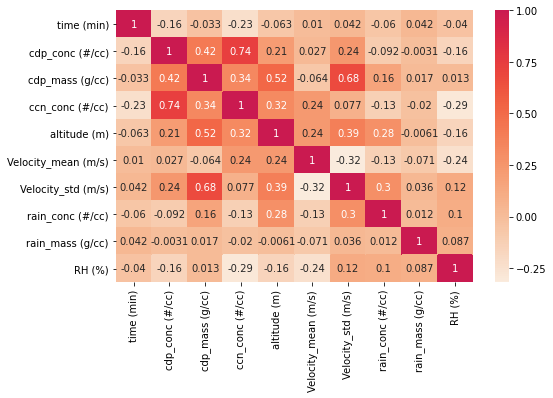

In [21]:
''' We use the pearson coefficient correlation to eastimate the relation, thus assuming that the data is
normally distributed and are linearly related.'''

a = df2.drop(columns = ['ambient_temp (degC)', 'dew_pt (degC)', 'non-nan counter']).corr(method = 'pearson')
sn.heatmap(a, cmap = 'rocket_r', center = 1, annot = True)
plt.rcParams["figure.figsize"] = (10, 8)
plt.show()


#### Linear Regression calculations

In [22]:
# 'X' is the feature matrix of all the independent variables.

X = np.vstack((np.array(df2['ccn_conc (#/cc)']), 
               np.array(df2['cdp_mass (g/cc)']), 
               np.array(df2['Velocity_mean (m/s)']), 
               np.array(df2['Velocity_std (m/s)']), 
               np.array(df2['altitude (m)']), 
               np.array(df2['RH (%)']),
               np.array(df2['rain_conc (#/cc)']),
               np.array(df2['rain_mass (g/cc)'])
              )).T

y = np.array(df2['cdp_conc (#/cc)'])

reg = LinearRegression(fit_intercept = False).fit(X, y)
 
print(f'R^2: {reg.score(X, y):1.3f}')
print(f'Intercept: {reg.intercept_}')
print(f'coefficients: \n{reg.coef_}')


R^2: 0.604
Intercept: 0.0
coefficients: 
[ 5.44194471e-01  9.94950035e+07 -1.99640250e+01  1.08261020e+01
 -3.06951404e-02  3.05172347e-01 -9.72406925e+00 -8.41029741e+03]


#### Analysis plots with analytical, observed and predicted values.

In [23]:
cdp_pinsky = np.array(CDC_pinsky(df2['ambient_temp (degC)'] + 273.15, df2['ccn_conc (#/cc)'], df2['Velocity_std (m/s)'], k = 0.5))

x1 = np.array(df2['cdp_conc (#/cc)'])[:, None] # observed output
x2 = np.array(cdp_pinsky)[:, None] # analytical output
x3 = np.array(reg.predict(X))[:, None] # Feature Matrix (F.R)

reg2 = LinearRegression(fit_intercept = False).fit(x1, x2)
reg3 = LinearRegression(fit_intercept = False).fit(x1, x3)

print(f'Analytical vs Observed regression R^2: {reg2.score(x1, x2):1.3f}')
print(f'Predicted vs Observed regression R^2: {reg3.score(x1, x3):1.3f}')

Analytical vs Observed regression R^2: 0.445
Predicted vs Observed regression R^2: 0.488


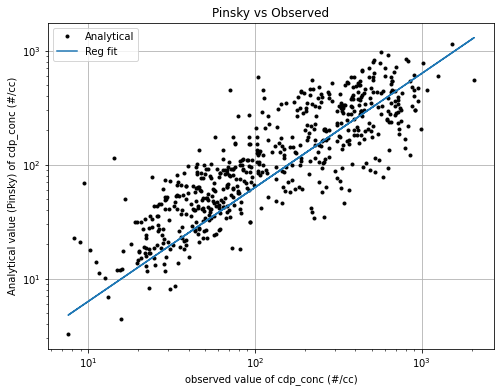

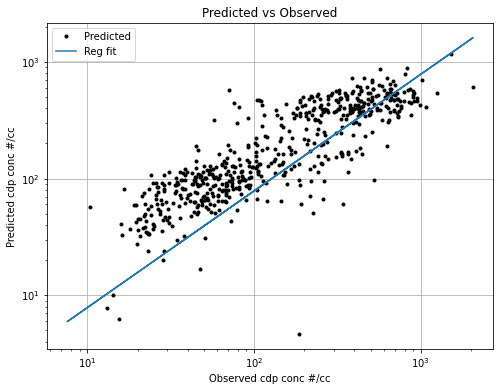

In [36]:
plt.figure(figsize = (8, 6))
plt.loglog(x1, x2, 'k.', label = 'Analytical')
plt.loglog(x1, reg2.predict(x1), label = 'Reg fit')
plt.xlabel('observed value of cdp_conc (#/cc)')
plt.ylabel('Analytical value (Pinsky) of cdp_conc (#/cc)')
plt.legend()
plt.title('Pinsky vs Observed')
plt.grid()
plt.show()

plt.figure(figsize = (8, 6))
plt.loglog(x1,x3, 'k.', label = 'Predicted')
plt.loglog(x1,reg3.predict(x1), label = 'Reg fit')
plt.legend()
plt.title('Predicted vs Observed')
plt.xlabel('Observed cdp conc #/cc')
plt.ylabel('Predicted cdp conc #/cc')
plt.grid()
plt.show()

#### Isolating data based on rain and no-rain

In [37]:
df3 = pd.read_csv('clean_data_with_rain.csv')
df3

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc),RH (%)
0,1038,525.690667,1.919149e-07,156.452830,963.566667,23.841667,20.235000,0.369500,0.532001,3,0.000000,0.000000e+00,80.261559
1,1039,368.329500,1.454731e-07,303.037500,1088.200000,23.096667,18.541667,0.256750,0.603507,2,0.000005,0.000000e+00,75.557647
2,1040,102.763850,3.613746e-07,157.620000,1106.700000,22.728333,19.518333,-3.667917,3.206158,6,0.006904,7.544186e-12,82.114718
3,1041,91.984218,3.244988e-07,141.256250,1101.366667,22.521667,20.270000,-2.146750,4.388065,22,0.013811,1.702631e-11,87.115427
4,1044,104.497209,3.478628e-07,115.815385,1106.300000,22.250000,21.186667,-2.470514,4.703326,35,0.000000,5.770725e-11,93.708633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,1039,336.723125,1.939796e-06,252.366667,5410.750000,-4.995000,-12.473333,2.724875,3.456326,8,0.856624,0.000000e+00,55.785574
577,1041,64.223822,3.003772e-07,137.113043,5669.283333,-6.058333,-9.260000,2.410944,0.979870,9,0.282132,5.079032e-08,78.071209
578,1043,84.528400,7.576585e-07,162.792453,5809.600000,-8.041667,-10.925000,1.837099,0.308029,4,0.000021,1.862939e-11,79.737525
579,1044,73.727075,5.766109e-07,155.333333,5816.183333,-8.351667,-12.308333,3.934125,1.480924,4,0.000468,7.077102e-10,73.125344


#### Neural Network design

1. Create the features matrix and the labels.
2. Scale the features to 0-1 range.
3. perform the k-fold validation as we donot have big-data.
4. Fit both the models through a pipeline
5. check you fit through the validation score (you need it to be minimum).


In [40]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [96]:
X = np.vstack((np.array(df2['ccn_conc (#/cc)']), 
               np.array(df2['cdp_mass (g/cc)']), 
               np.array(df2['Velocity_mean (m/s)']), 
               np.array(df2['Velocity_std (m/s)']), 
               np.array(df2['altitude (m)']), 
               np.array(df2['RH (%)']),
               np.array(df2['rain_conc (#/cc)']),
#                np.array(df2['rain_mass (g/cc)'])
              )).T

y = np.array(df2['cdp_conc (#/cc)'])

# scaler = preprocessing.StandardScaler() 

# scaler = preprocessing.MinMaxScaler()
model =  MLPRegressor(hidden_layer_sizes=(6,6), max_iter = 150, activation='relu', 
                      solver='lbfgs', alpha = 0.05, learning_rate = 'adaptive') 

pipe = Pipeline([
#     ('scale', scaler),
    ('NN', model)])

kf = KFold(n_splits=5)

for train, test in kf.split(X):
    pipe.fit(X[train], y[train])
    print(pipe.score(X[train], y[train]), pipe.score(X[test], y[test]))

0.5630347244671539 0.43446202122176825
0.5642774150577394 0.32486288873586444
0.5405180047426332 -0.1596158884298997
0.6588290890794861 0.1887369578767265
0.644413320565686 0.13236394633223902


In [97]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X, y, cv=5)
print(scores)
print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std() * 2:0.2f})")

[-2.99202176  0.128383   -5.82252816  0.26660719  0.13424987]
Accuracy: -1.66 (+/- 4.84)


In [98]:
pipe.get_params().keys()


dict_keys(['memory', 'steps', 'verbose', 'NN', 'NN__activation', 'NN__alpha', 'NN__batch_size', 'NN__beta_1', 'NN__beta_2', 'NN__early_stopping', 'NN__epsilon', 'NN__hidden_layer_sizes', 'NN__learning_rate', 'NN__learning_rate_init', 'NN__max_iter', 'NN__momentum', 'NN__n_iter_no_change', 'NN__nesterovs_momentum', 'NN__power_t', 'NN__random_state', 'NN__shuffle', 'NN__solver', 'NN__tol', 'NN__validation_fraction', 'NN__verbose', 'NN__warm_start'])

In [99]:
parameter_space = {
    'NN__hidden_layer_sizes': [(6,), (5,2), (6,6), (12,15)],
    'NN__alpha': [0.0001, 0.05],
    'NN__learning_rate': ['constant','adaptive'],
}

In [100]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipe, parameter_space)
clf.fit(X[train], y[train])

print(clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


{'NN__alpha': 0.0001, 'NN__hidden_layer_sizes': (6,), 'NN__learning_rate': 'adaptive'}


In [101]:
from sklearn.model_selection import ShuffleSplit

for i in range(15):
    n_samples = X.shape[0]
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    scores = cross_val_score(model, X, y, cv=cv)

    print(scores)
    print(f"Accuracy: {scores.mean():0.2f} (+/- {scores.std() * 2:0.2f})")

[ 0.55774318  0.69854905  0.664129   -0.01645855  0.62311818]
Accuracy: 0.51 (+/- 0.53)
[0.53986528 0.73074722 0.54963132 0.43859686 0.61821044]
Accuracy: 0.58 (+/- 0.19)
[0.59908779 0.65320793 0.6141343  0.41771779 0.67312239]
Accuracy: 0.59 (+/- 0.18)
[0.54607803 0.66421659 0.57563456 0.44250252 0.62704616]
Accuracy: 0.57 (+/- 0.15)
[-0.01369326  0.68183877  0.58727723  0.45290308  0.65981191]
Accuracy: 0.47 (+/- 0.51)
[ 0.54949486  0.68826923  0.54969405 -0.01645854  0.59750655]
Accuracy: 0.47 (+/- 0.50)
[0.45044835 0.73802101 0.56971355 0.47359646 0.6507085 ]
Accuracy: 0.58 (+/- 0.22)
[ 0.55847965  0.72229035  0.5750797  -0.01645851  0.64920439]
Accuracy: 0.50 (+/- 0.53)
[ 0.60189553  0.73147452 -0.00449818  0.46458917  0.62789785]
Accuracy: 0.48 (+/- 0.52)
[ 0.52684416  0.67940638  0.58652785  0.49066628 -0.00746533]
Accuracy: 0.46 (+/- 0.48)
[0.60317332 0.67160215 0.57443511 0.4653892  0.62858093]
Accuracy: 0.59 (+/- 0.14)
[ 0.54233213  0.71222574 -0.00449055  0.42664419  0.60821

In [107]:
from sklearn.model_selection import cross_val_predict

n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
# cross_val_predict(model, X, y, cv=cv)
print(cv.metrics)

AttributeError: 'ShuffleSplit' object has no attribute 'metrics'

#### Rain/ No rain cloud droplet analysis

In [62]:
# splitting data based on rain concentration
# split the rain data based on the concentration value of 1000 #/m3. 
no_rain_data = df3[df3['rain_conc (#/cc)'] <= 1e-3] # units in #/cc.
rain_data = df3[df3['rain_conc (#/cc)'] > 1e-3]


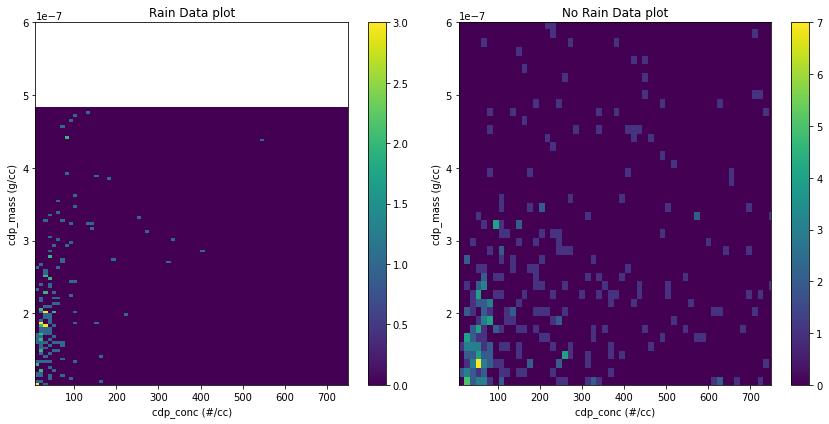

In [63]:
# 2D histogram for rain data
cdp_conc1 = rain_data['cdp_conc (#/cc)']
cdp_mass1 = rain_data['cdp_mass (g/cc)']

cdp_conc2 = no_rain_data['cdp_conc (#/cc)']
cdp_mass2 = no_rain_data['cdp_mass (g/cc)']

x1 = cdp_conc1
y1 = cdp_mass1

x2 = cdp_conc2
y2 = cdp_mass2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,6))
h1 = ax1.hist2d(x1, y1, bins = 100, range = [[min(x1), max(x1)], [min(y1), np.mean(y1)]])
ax1.set_xlim(min(x1),750)
ax1.set_ylim(min(y1), 6e-7)
ax1.set_ylabel('cdp_mass (g/cc)')
ax1.set_xlabel('cdp_conc (#/cc)')
ax1.set_title('Rain Data plot')
fig.colorbar(h1[3], ax=ax1)

h2 = ax2.hist2d(x2, y2, bins = 150, range = [[min(x2), max(x2)], [min(y2), max(y2)]])
ax2.set_xlim(min(x2),750)
ax2.set_ylim(min(y2), 6e-7)
ax2.set_ylabel('cdp_mass (g/cc)')
ax2.set_xlabel('cdp_conc (#/cc)')
ax2.set_title('No Rain Data plot')
fig.colorbar(h2[3], ax=ax2)

plt.tight_layout()

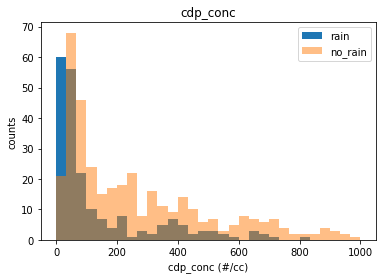

In [8]:
# histograms plots for estimating how much rain is present in the observations. 

plt.hist(x1, bins = 30,range = (0,1000), label = 'rain')
plt.hist(x2, bins = 30, range = (0,1000),alpha = 0.5, label = 'no_rain')
plt.xlabel('cdp_conc (#/cc)')
plt.ylabel('counts')
plt.title('cdp_conc')
plt.legend()
plt.show()

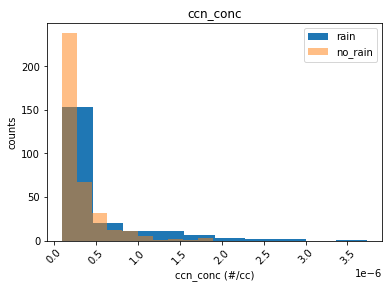

In [9]:
plt.hist(y1, label = 'rain')
plt.hist(y2, alpha = 0.5, label = 'no_rain')
plt.xlabel('ccn_conc (#/cc)')
plt.ylabel('counts')
plt.xticks(rotation = 45)
plt.ticklabel_format(axis = 'x', scilimits = (-1,-3))
plt.title('ccn_conc')
plt.legend()
plt.show()

In [16]:
from sklearn.model_selection import train_test_split

X = np.array(rain_data[['altitude (m)', 'cdp_conc (#/cc)', 'Velocity_mean (m/s)','Velocity_std (m/s)', 'cdp_mass (g/cc)']])
y = rain_data['rain_mass (g/cc)']

(X_train, X_test,
 y_train, y_test) = train_test_split(X, y,
                                     test_size=0.2,
                                     shuffle=True,
                                     random_state=3)

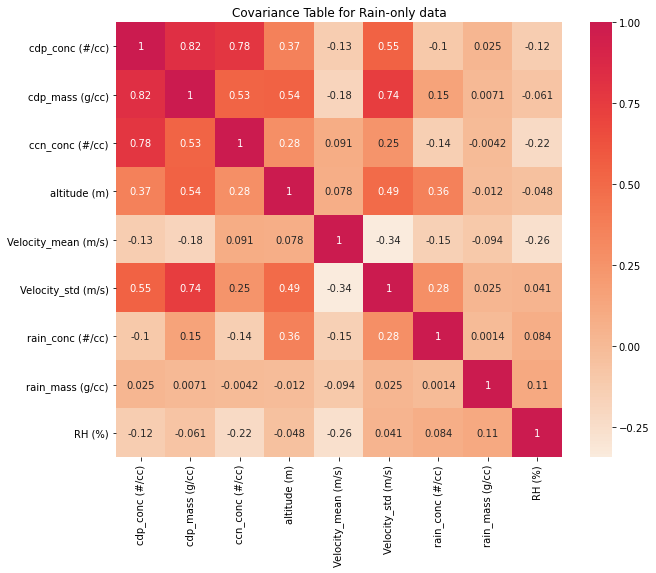

In [68]:
# covariance table for data with significant rain droplet concentration. 

a = rain_data.drop(columns = ['time (min)', 'ambient_temp (degC)', 'dew_pt (degC)', 'non-nan counter']).corr(method = 'pearson')
sn.heatmap(a, cmap = 'rocket_r', center = 1, annot = True)
plt.rcParams["figure.figsize"] = (10, 8)
plt.title('Covariance Table for Rain-only data')
plt.show()


#### Experimenting with other non-linear regression models like Decision Tree and Random Forest. 

In [18]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

tree.predict(X_test)
tree.score(X_test, y_test)

-1774.8735530521537

In [20]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=10, bootstrap=False, random_state=5)

forest.fit(X_train, y_train)
forest.predict(X_test)
forest.score(X_test, y_test)

-1774.8735530521537

### Hypothesis testing

#### T vs z plot for inversion

In [69]:
df4 = df3.sort_values('altitude (m)').reset_index(drop=True)
df4

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc),RH (%)
0,1040,67.675925,1.394175e-07,112.032000,361.583333,24.068333,22.390000,-0.820250,0.130242,4,0.000000,0.000000e+00,90.356948
1,1039,43.753400,1.695218e-07,64.800000,557.050000,23.283333,20.943333,0.528500,0.104983,1,0.000000,0.000000e+00,86.712433
2,1115,48.729350,1.219569e-07,79.704545,586.733333,21.588333,20.248333,0.152250,0.035267,2,0.001534,0.000000e+00,92.091811
3,1060,28.722137,2.011212e-07,104.693103,587.633333,22.595000,23.261667,-0.459342,0.855725,19,0.112679,0.000000e+00,104.119572
4,1114,52.711633,1.454350e-07,76.741176,587.966667,21.640000,20.166667,0.104711,0.185076,3,0.000783,0.000000e+00,91.339029
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,1041,64.223822,3.003772e-07,137.113043,5669.283333,-6.058333,-9.260000,2.410944,0.979870,9,0.282132,5.079032e-08,78.071209
577,1045,34.903100,1.519382e-07,186.536207,5780.066667,-8.015000,-13.271667,1.089500,0.017775,1,0.000000,0.000000e+00,65.903545
578,1043,84.528400,7.576585e-07,162.792453,5809.600000,-8.041667,-10.925000,1.837099,0.308029,4,0.000021,1.862939e-11,79.737525
579,1044,73.727075,5.766109e-07,155.333333,5816.183333,-8.351667,-12.308333,3.934125,1.480924,4,0.000468,7.077102e-10,73.125344


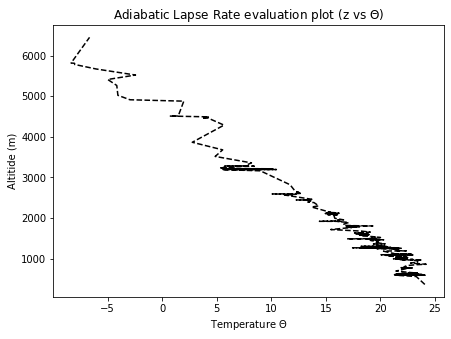

In [105]:
y = df4['altitude (m)']
x = df4['ambient_temp (degC)']

plt.figure(figsize = (7, 5))
plt.plot(x, y, 'k--')
plt.xlabel('Temperature $\Theta$')
plt.ylabel('Altitide (m)')
plt.title('Adiabatic Lapse Rate evaluation plot (z vs $\Theta$)')
plt.show()

In [95]:
print(f'Maximum altitde the aircraft reached: {max(y):1.1f} m,\nMinimum altitide recorded: {min(y):1.1f} m')

Maximum altitde the aircraft reached: 6448.4 m,
Minimum altitide recorded: 361.6 m


#### Neural Network with log values of rain mass and conc

In [41]:
X = np.vstack((np.array(df3['ccn_conc (#/cc)']), 
               np.array(df3['cdp_mass (g/cc)']), 
               np.array(df3['Velocity_mean (m/s)']), 
               np.array(df3['Velocity_std (m/s)']), 
               np.array(df3['altitude (m)']), 
               np.array(df3['RH (%)']),
               np.array(df3['rain_conc (#/cc)']),
               np.array(df3['rain_mass (g/cc)'])
              )).T

y = np.array(df3['cdp_conc (#/cc)'])


In [42]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold

In [43]:
scaler = preprocessing.MinMaxScaler()
model =  MLPRegressor(hidden_layer_sizes=(6,6), max_iter = 150, activation='relu', solver='lbfgs', alpha = 0.05, learning_rate = 'adaptive')

pipe = Pipeline([('scale', scaler),
                 ('NN', model)])

kf = KFold(n_splits=5)

for train, test in kf.split(X):
    pipe.fit(X[train], y[train])
    print(pipe.score(X[train], y[train]), pipe.score(X[test], y[test]))

-1.1257661469699087e-13 -2.992846455967014
0.6651789222720736 -6.081303575682377
0.6843120018087425 0.11560140866518286
0.7207464217667074 0.06878933764849704
0.7800522437082702 -0.8746973112226015


In [44]:
model =  MLPRegressor(hidden_layer_sizes=(6,6), max_iter = 150, 
                      activation='relu', solver='lbfgs', 
                      alpha = 0.05, learning_rate = 'adaptive')

kf = KFold(n_splits=5)

print('Train  Test')
for train, test in kf.split(X):
    model.fit(X[train], y[train])
    print(f'{model.score(X[train], y[train]):1.3f}, {model.score(X[test], y[test]):1.3f}')

Train  Test
0.591, 0.153
0.537, 0.260
0.583, -0.083
0.568, 0.163
0.642, 0.163


#### Dividing the data based on altitude

In [66]:
range1 = df4.loc[df4['altitude (m)'] < 650]

In [75]:
range2 = df4.loc[(df4['altitude (m)'] > 650) & (df4['altitude (m)'] < 1200)]

In [76]:
range3 = df4.loc[(df4['altitude (m)'] > 1200) & (df4['altitude (m)'] < 2000)]

In [82]:
range4 = df4.loc[df4['altitude (m)'] > 2000]

In [77]:
len(range1)

182

In [88]:
X = np.vstack((np.array(range1['ccn_conc (#/cc)']), 
               np.array(range1['cdp_mass (g/cc)']), 
               np.array(range1['Velocity_mean (m/s)']), 
               np.array(range1['Velocity_std (m/s)']), 
               np.array(range1['altitude (m)']), 
               np.array(range1['RH (%)']),
               np.array(range1['rain_conc (#/cc)']),
               np.array(range1['rain_mass (g/cc)'])
              )).T

y = np.array(range1['cdp_conc (#/cc)'])

reg = LinearRegression(fit_intercept = False).fit(X, y)
c1 = reg.coef_ 
print(f'R^2: {reg.score(X, y):1.3f}')
print(f'Intercept: {reg.intercept_}')
print(f'coefficients: \n{reg.coef_}')


R^2: 0.432
Intercept: 0.0
coefficients: 
[ 6.67298950e-01  5.01346336e+07 -4.26970838e+00 -5.71282029e+00
  1.24078728e-01 -9.56433603e-01 -9.04779048e+00 -4.85899124e+07]


In [78]:
len(range2)

118

In [89]:
X = np.vstack((np.array(range2['ccn_conc (#/cc)']), 
               np.array(range2['cdp_mass (g/cc)']), 
               np.array(range2['Velocity_mean (m/s)']), 
               np.array(range2['Velocity_std (m/s)']), 
               np.array(range2['altitude (m)']), 
               np.array(range2['RH (%)']),
               np.array(range2['rain_conc (#/cc)']),
               np.array(range2['rain_mass (g/cc)'])
              )).T

y = np.array(range2['cdp_conc (#/cc)'])

reg = LinearRegression(fit_intercept = False).fit(X, y)
c2 = reg.coef_  
print(f'R^2: {reg.score(X, y):1.3f}')
print(f'Intercept: {reg.intercept_}')
print(f'coefficients: \n{reg.coef_}')


R^2: 0.812
Intercept: 0.0
coefficients: 
[ 8.29223013e-01  1.88739867e+08  2.68391618e-01  3.75030227e-01
  3.00310850e-02 -6.23321293e-01 -2.03340285e+03 -2.46035865e+08]


In [79]:
len(range3)

175

In [90]:
X = np.vstack((np.array(range3['ccn_conc (#/cc)']), 
               np.array(range3['cdp_mass (g/cc)']), 
               np.array(range3['Velocity_mean (m/s)']), 
               np.array(range3['Velocity_std (m/s)']), 
               np.array(range3['altitude (m)']), 
               np.array(range3['RH (%)']),
               np.array(range3['rain_conc (#/cc)']),
               np.array(range3['rain_mass (g/cc)'])
              )).T

y = np.array(range3['cdp_conc (#/cc)'])

reg = LinearRegression(fit_intercept = False).fit(X, y)
c3 = reg.coef_ 
print(f'R^2: {reg.score(X, y):1.3f}')
print(f'Intercept: {reg.intercept_}')
print(f'coefficients: \n{reg.coef_}')


R^2: 0.379
Intercept: 0.0
coefficients: 
[ 5.88015995e-01  1.26732845e+08 -6.36202908e+00  3.26991657e+01
 -1.30477592e-01  1.55981509e+00 -1.20077566e+01 -7.17659616e+04]


In [83]:
len(range4)

106

In [91]:
X = np.vstack((np.array(range4['ccn_conc (#/cc)']), 
               np.array(range4['cdp_mass (g/cc)']), 
               np.array(range4['Velocity_mean (m/s)']), 
               np.array(range4['Velocity_std (m/s)']), 
               np.array(range4['altitude (m)']), 
               np.array(range4['RH (%)']),
               np.array(range4['rain_conc (#/cc)']),
               np.array(range4['rain_mass (g/cc)'])
              )).T

y = np.array(range4['cdp_conc (#/cc)'])

reg = LinearRegression(fit_intercept = False).fit(X, y)
c4 = reg.coef_  
print(f'R^2: {reg.score(X, y):1.3f}')
print(f'Intercept: {reg.intercept_}')
print(f'coefficients: \n{reg.coef_}')


R^2: 0.701
Intercept: 0.0
coefficients: 
[ 3.67205467e-01  1.62309330e+08 -2.61758830e+01  4.03369140e+00
 -1.52027011e-02  7.23324511e-02 -1.58880805e+01  1.37196372e+07]


In [105]:
c = np.array([c1, c2,c3, c4]).T
c.shape

(8, 4)

In [106]:
c

array([[ 6.67298950e-01,  8.29223013e-01,  5.88015995e-01,
         3.67205467e-01],
       [ 5.01346336e+07,  1.88739867e+08,  1.26732845e+08,
         1.62309330e+08],
       [-4.26970838e+00,  2.68391618e-01, -6.36202908e+00,
        -2.61758830e+01],
       [-5.71282029e+00,  3.75030227e-01,  3.26991657e+01,
         4.03369140e+00],
       [ 1.24078728e-01,  3.00310850e-02, -1.30477592e-01,
        -1.52027011e-02],
       [-9.56433603e-01, -6.23321293e-01,  1.55981509e+00,
         7.23324511e-02],
       [-9.04779048e+00, -2.03340285e+03, -1.20077566e+01,
        -1.58880805e+01],
       [-4.85899124e+07, -2.46035865e+08, -7.17659616e+04,
         1.37196372e+07]])

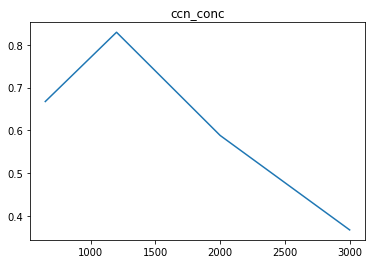

In [108]:
plt.title('ccn_conc')
plt.plot([650, 1200, 2000, 3000], c[0])


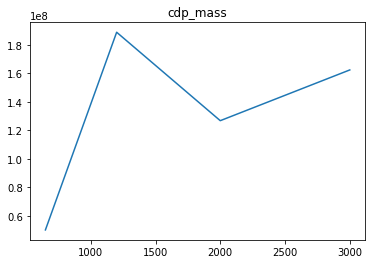

In [109]:
plt.title('cdp_mass')
plt.plot([650, 1200, 2000, 3000], c[1])